In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import sklearn.metrics as m
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import preprocessing
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.inspection import permutation_importance

   ID  Q_Age  Q_Gender  Q_City  Q1  Q4  Q7  Q13_1  Q13_2  Q13_3  ...  Q27_5  \
0  18     71         1       4   2   3   3      1      1      0  ...      0   
1  23     65         2       5   1   1   2      1      0      0  ...      0   
2  30     77         1       4   1   1   2      0      0      1  ...      0   
3  31     75         1       4   2   3   3      0      0      1  ...      0   
4  34     73         2       4   1   2   2      1      0      0  ...      0   

   Q27_6  Q27_7  Q27_8  Q27_9  Q27_10  Q28  Q29  Q32  Price_elasticity  
0      0      0      0      0       0    4    2    3          0.304904  
1      0      0      0      0       0    1    2    1          0.045513  
2      0      1      0      0       0    4    2    1         -0.116270  
3      0      1      0      0       0    4    2    2          0.033317  
4      0      1      0      0       0    4    2    6          0.167799  

[5 rows x 42 columns]
(1136, 42)


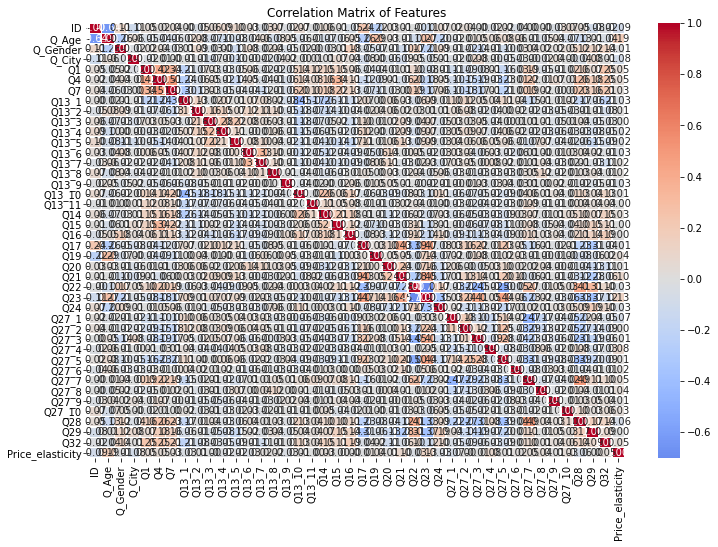

Top 20 correlating feature pairs (|r| < 1):
Feature1 Feature2  Correlation
     Q23      Q22    -0.700303
   Q_Age       ID    -0.640694
      Q7       Q4     0.514710
   Q27_5      Q22    -0.498461
     Q28    Q27_7     0.494290
   Q27_7    Q27_1    -0.467332
     Q23      Q17     0.465333
   Q27_3      Q22    -0.453587
     Q23      Q21     0.447126
  Q13_10    Q13_1    -0.445271
   Q27_5      Q23     0.443799
     Q21      Q17     0.425628
      Q4       Q1     0.418065
     Q28      Q22     0.407228
   Q27_3      Q23     0.406247
     Q22      Q17    -0.387714
     Q28    Q27_5    -0.385802
     Q29      Q23    -0.373753
     Q24      Q23    -0.346694
      Q7       Q1     0.338951
Counts of each class:
0.0    446
1.0    403
Name: is_price_responsive, dtype: int64
Binary columns (already encoded): ['Q13_1', 'Q13_2', 'Q13_3', 'Q13_4', 'Q13_5', 'Q13_6', 'Q13_7', 'Q13_8', 'Q13_9', 'Q13_10', 'Q13_11', 'Q27_1', 'Q27_2', 'Q27_3', 'Q27_4', 'Q27_5', 'Q27_6', 'Q27_7', 'Q27_8', 'Q27_9']
Cate

In [2]:
df = pd.read_csv('survey_PE.csv')
print(df.head())
print(df.shape)


#-------------------------------------------------------CORRELATION MATRIX------------------------------------------------------
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            center=0,
            linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.show()
upper_triangle = np.triu(np.ones_like(corr_matrix, dtype=bool))
high_corr_pairs = (corr_matrix.where(~upper_triangle)
                  .stack()
                  .reset_index()
                  .rename(columns={'level_0':'Feature1', 'level_1':'Feature2', 0:'Correlation'}))
high_corr_pairs = (high_corr_pairs[abs(high_corr_pairs['Correlation']) < 1]
                  .sort_values(by='Correlation', key=abs, ascending=False))
top_n = 20
print(f"Top {top_n} correlating feature pairs (|r| < 1):")
print(high_corr_pairs.head(top_n).to_string(index=False))

#-------------------------------------------------------MAKE TO CLASSIFICATION PROBLEM----------------------------------------------------
threshold = -0.0331
treshold2 = 0.0328
df['is_price_responsive'] = df['Price_elasticity'].apply(
    lambda x: 1 if x < threshold else (0 if x > treshold2 else None)
)
df = df.dropna(subset=['is_price_responsive'])
counts = df['is_price_responsive'].value_counts()
print("Counts of each class:")
print(counts)

# Feature engineering (before splitting and preprocessing)
df = df.drop(columns=["ID", "Price_elasticity", 'Q22', 'Q20', 'Q27_10'])

# Define X and y
X = df.drop(columns=["is_price_responsive"])
y = df['is_price_responsive']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#-------------------------------------------------------DATA PREPROCESSING----------------------------------------------------
# Identify column types
binary_cols = []  # Columns with only 0 and 1 values
categorical_cols = []  # Categorical columns that need one-hot encoding
numeric_cols = ['Q_Age']  # True numeric columns

# Identify binary and categorical columns
for col in X.columns:
    if col == 'Q_Age':  # Skip the engineered feature and age
        continue
    unique_vals = X[col].unique()
    if set(unique_vals).issubset({0, 1}):  # Binary columns (already encoded)
        binary_cols.append(col)
    elif len(unique_vals) > 2:  # Multi-class categorical
        categorical_cols.append(col)
    else:  # Binary categorical but not 0/1
        categorical_cols.append(col)

print(f"Binary columns (already encoded): {binary_cols}")
print(f"Categorical columns (need one-hot encoding): {categorical_cols}")
print(f"Numeric columns: {numeric_cols}")

#-------------------------------------------------TREE-BASED MODEL PREPARATION----------------------------------------------------
# For tree-based models, minimal preprocessing is needed
# Just convert any string categorical variables to numeric (which appears already done)
X_tree = X.copy()

# This split is just to demonstrate - we're reusing the same split from above
X_train_tree, X_test_tree = X_train.copy(), X_test.copy()

# Calculate VIF for tree model features (optional - just to check multicollinearity)
print("\nVIF for Tree-Based Model Features:")
vif_data_tree = pd.DataFrame()
vif_data_tree["Feature"] = X_train_tree.columns
vif_data_tree["VIF"] = [variance_inflation_factor(X_train_tree.values, i) for i in range(X_train_tree.shape[1])]
print(vif_data_tree.sort_values("VIF", ascending=False))

#-------------------------------------------------LINEAR MODEL PREPARATION----------------------------------------------------
# For linear models, we need scaling and one-hot encoding

numeric_cols = ['Q_Age']  # True continuous variables

# Ordinal features (keep as-is, no scaling)
ordinal_cols = ['Q14', 'Q16', 'Q19', 'Q21', 'Q23']  # Already encoded as 1, 2, 3, ...

# Nominal features (one-hot encode)
nominal_cols = [col for col in categorical_cols if col not in ordinal_cols]

# Create preprocessing pipeline for linear models
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),       # Scale true numerics
        ('ordinal', 'passthrough', ordinal_cols),      # Leave ordinal as-is
        ('cat', OneHotEncoder(drop='first', sparse_output=False), nominal_cols)  # One-hot nominal
    ],
    remainder='passthrough'  # Keep binary cols (Q13_*, Q27_*, etc.) unchanged
)

# Join the data for preprocessing 
X_combined = pd.concat([X_train, X_test])

# Fit the preprocessor on all data
preprocessor.fit(X_combined)

# Then transform train and test separately
X_train_linear_array = preprocessor.transform(X_train)
X_test_linear_array = preprocessor.transform(X_test)

# Get correct feature names from the transformer itself
feature_names = preprocessor.get_feature_names_out()

# Create DataFrames with correct column names
X_train_linear = pd.DataFrame(X_train_linear_array, columns=feature_names)
X_test_linear = pd.DataFrame(X_test_linear_array, columns=feature_names)

# Calculate VIF for linear model features
print("\nVIF for Linear Model Features:")
vif_data_linear = pd.DataFrame()
vif_data_linear["Feature"] = X_train_linear.columns
vif_data_linear["VIF"] = [variance_inflation_factor(X_train_linear.values, i) for i in range(X_train_linear.shape[1])]
print(vif_data_linear.sort_values("VIF", ascending=False))

# Print shapes to confirm the transformations
print("\nData shapes:")
print(f"Tree-based model training data: {X_train_tree.shape}")
print(f"Linear model training data: {X_train_linear.shape}")

X_train_linear = X_train_linear.drop(columns=['cat__Q17_7'])
X_test_linear = X_test_linear.drop(columns=['cat__Q17_7'])



# Now you can train your models:
# Tree-based model: Use X_train_tree and y_train
# Linear model: Use X_train_linear and y_train

Logistic regression
0.5411764705882353
              precision    recall  f1-score   support

         0.0       0.55      0.59      0.57        88
         1.0       0.53      0.49      0.51        82

    accuracy                           0.54       170
   macro avg       0.54      0.54      0.54       170
weighted avg       0.54      0.54      0.54       170

[[52 36]
 [42 40]]


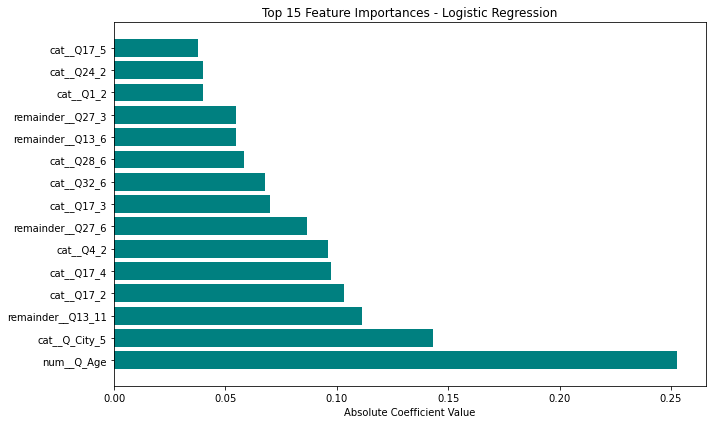

Best C: {'C': 1}
SVM
0.5470588235294118
              precision    recall  f1-score   support

         0.0       0.56      0.57      0.56        88
         1.0       0.53      0.52      0.53        82

    accuracy                           0.55       170
   macro avg       0.55      0.55      0.55       170
weighted avg       0.55      0.55      0.55       170

[[50 38]
 [39 43]]


In [3]:
#-----------------------------------------LINEAR MODELS-----------------------------------------------------------------------

#-----------------------------------------LOGISTICAL REGRESSION---------------------------------------------------------------

model=LogisticRegression(solver='liblinear', C=0.01, class_weight='balanced')
model.fit(X_train_linear,y_train)

label_pred_LR=model.predict(X_test_linear)

print('Logistic regression')
print(m.accuracy_score(y_test,label_pred_LR))
print(m.classification_report(y_test,label_pred_LR))
print(m.confusion_matrix(y_test,label_pred_LR))

importances = np.abs(model.coef_[0])  # Use [0] for binary classification
feature_names = preprocessor.get_feature_names_out()

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances - Logistic Regression")
plt.barh(range(15), importances[indices][:15], align='center', color='teal')
plt.yticks(range(15), feature_names[indices][:15])
plt.xlabel("Absolute Coefficient Value")
plt.tight_layout()
plt.show()

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=10000, solver='saga', class_weight='balanced'), 
                    param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_linear, y_train)

print("Best C:", grid.best_params_)

#-----------------------------------------SVM----------------------------------------------------------------------------------

svm = SVC(kernel='rbf', class_weight='balanced', probability=True)
svm.fit(X_train_linear, y_train)

svm_preds = svm.predict(X_test_linear)

print('SVM')
print(m.accuracy_score(y_test,svm_preds))
print(m.classification_report(y_test,svm_preds))
print(m.confusion_matrix(y_test,svm_preds))

result = permutation_importance(
    svm, 
    X_test_linear,  # Use test data to avoid bias
    y_test, 
    n_repeats=10,    # Number of shuffles per feature
    random_state=42
)

# Get feature importances and names
importances = result.importances_mean
feature_names = preprocessor.get_feature_names_out()

# Sort features by importance
indices = np.argsort(importances)[::-1]




Random Forest Classifier
0.48823529411764705
              precision    recall  f1-score   support

         0.0       0.51      0.51      0.51        88
         1.0       0.47      0.46      0.47        82

    accuracy                           0.49       170
   macro avg       0.49      0.49      0.49       170
weighted avg       0.49      0.49      0.49       170

[[45 43]
 [44 38]]


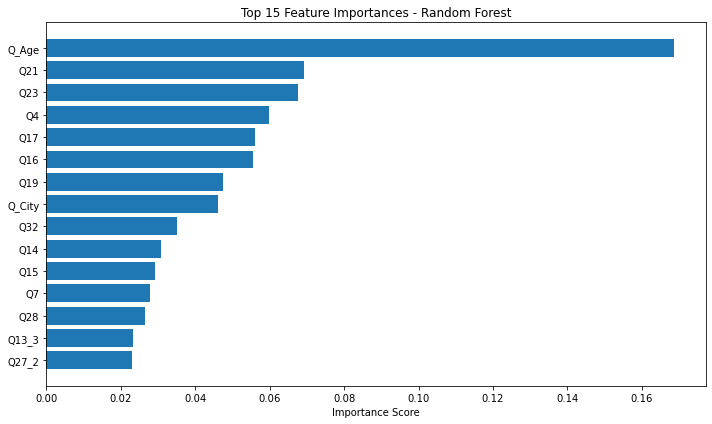

C:\Users\idawh\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [05:06:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classifier
0.48823529411764705
              precision    recall  f1-score   support

         0.0       0.51      0.52      0.51        88
         1.0       0.47      0.45      0.46        82

    accuracy                           0.49       170
   macro avg       0.49      0.49      0.49       170
weighted avg       0.49      0.49      0.49       170

[[46 42]
 [45 37]]


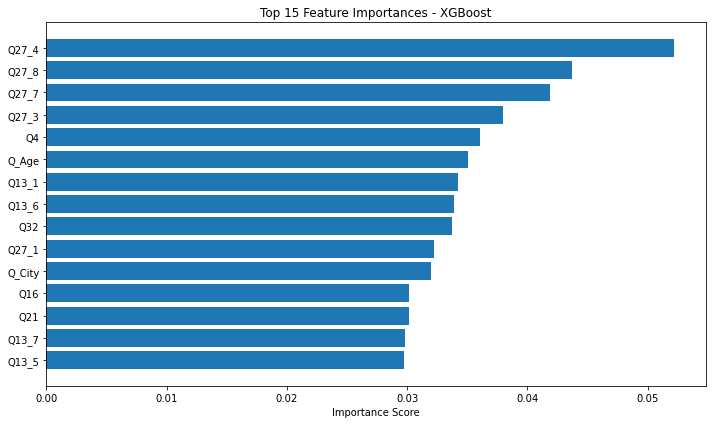

[LightGBM] [Info] Number of positive: 321, number of negative: 358
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 679, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [4]:
#-----------------------------------------TREE-BASED MODELS-----------------------------------------------------------------

#-----------------------------------------RANDOM FOREST------------------------------------------------------------------------
#param_grid = {
#    'n_estimators': [100, 300],
 #   'max_depth': [3, 5],
 #   'min_samples_split': [2, 5],
 #   'min_samples_leaf': [1, 3],
  #  'max_features': ['sqrt', 'log2']
#}

rf_model = RandomForestClassifier(
    random_state=42,
    max_depth=12,
    max_features='sqrt',
    min_samples_leaf=3,
    min_samples_split=2,
    n_estimators=100
)


rf_model.fit(X_train_tree, y_train)
rf_preds = rf_model.predict(X_test_tree)

print('Random Forest Classifier')
print(m.accuracy_score(y_test,rf_preds))
print(m.classification_report(y_test,rf_preds))
print(m.confusion_matrix(y_test,rf_preds))
#print("Best RF Params:", rf_model.best_params_)

# Plot feature importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances - Random Forest")
plt.barh(X.columns[indices][:15][::-1], importances[indices][:15][::-1])
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

#---------------------------------------XGBoost--------------------------------------------------------------------------------
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_tree, y_train)
xgb_preds = xgb_model.predict(X_test_tree)

print('XGBoost Classifier')
print(m.accuracy_score(y_test,xgb_preds))
print(m.classification_report(y_test,xgb_preds))
print(m.confusion_matrix(y_test,xgb_preds))

# Plot feature importance
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances - XGBoost")
plt.barh(X.columns[indices][:15][::-1], importances[indices][:15][::-1])
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

#-----------------------------------------LIGHTGBM-----------------------------------------------------------------------------

from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Use top features from feature selection if you want
# X_train_selected = X_train_scaled[top_15_features]

lgbm_model = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    num_leaves=31,
    class_weight='balanced',  # handles imbalance like in LogisticRegression
    random_state=42
)

lgbm_model.fit(X_train_tree, y_train)
y_pred_lgbm = lgbm_model.predict(X_test_tree)

# Evaluation
print("LightGBM Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print(classification_report(y_test, y_pred_lgbm))
print(confusion_matrix(y_test, y_pred_lgbm))

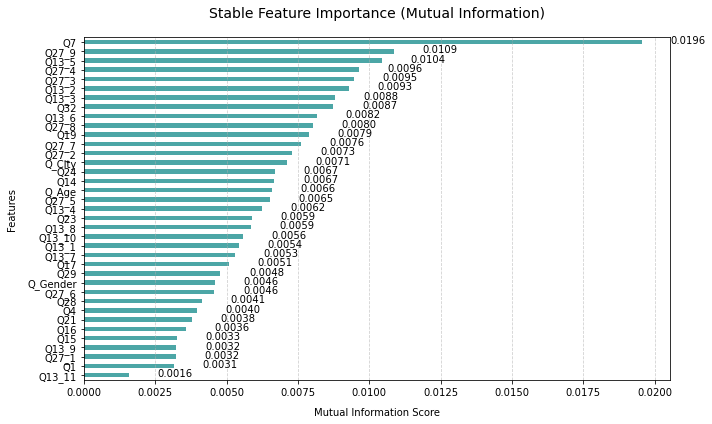

Top 20 stable features: ['Q7', 'Q27_9', 'Q13_5', 'Q27_4', 'Q27_3', 'Q13_2', 'Q13_3', 'Q32', 'Q13_6', 'Q27_8', 'Q19', 'Q27_7', 'Q27_2', 'Q_City', 'Q24', 'Q14', 'Q_Age', 'Q27_5', 'Q13_4', 'Q23']
=== Sorted Feature Importance ===
Q7          0.0196
Q27_9       0.0109
Q13_5       0.0104
Q27_4       0.0096
Q27_3       0.0095
Q13_2       0.0093
Q13_3       0.0088
Q32         0.0087
Q13_6       0.0082
Q27_8       0.0080
Q19         0.0079
Q27_7       0.0076
Q27_2       0.0073
Q_City      0.0071
Q24         0.0067
Q14         0.0067
Q_Age       0.0066
Q27_5       0.0065
Q13_4       0.0062
Q23         0.0059
Q13_8       0.0059
Q13_10      0.0056
Q13_1       0.0054
Q13_7       0.0053
Q17         0.0051
Q29         0.0048
Q_Gender    0.0046
Q27_6       0.0046
Q28         0.0041
Q4          0.0040
Q21         0.0038
Q16         0.0036
Q15         0.0033
Q13_9       0.0032
Q27_1       0.0032
Q1          0.0031
Q13_11      0.0016




NameError: name 'X_train_scaled' is not defined

In [5]:

#---------------------------------------------------------INFORMATION GAIN-----------------------------------------------------

from sklearn.feature_selection import mutual_info_classif

n = 15
n_neighbors = 5
base_random_state = 42

mi_scores = np.zeros((n, X.shape[1]))

for i in range(n):
    mi_scores[i] = mutual_info_classif(
        X, y,
        n_neighbors=n_neighbors,
        random_state=base_random_state + i 
    )
    
stable_mi = pd.Series(mi_scores.mean(axis=0), index=X.columns)

stable_mi = stable_mi[stable_mi > 0.001] 

plt.figure(figsize=(10, 6))
ax = stable_mi.sort_values().plot(
    kind='barh', 
    color='teal', 
    alpha=0.7
)

for i in ax.patches:
    ax.text(
        i.get_width() + 0.001, 
        i.get_y() + 0.1,
        f'{i.get_width():.4f}',  # Format to 4 decimal places
        fontsize=10
    )

plt.title('Stable Feature Importance (Mutual Information)', pad=20, fontsize=14)
plt.xlabel('Mutual Information Score', labelpad=10)
plt.ylabel('Features', labelpad=10)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

N = 20  # Adjust as needed
top_features = stable_mi.nlargest(N).index.tolist()
print(f"Top {N} stable features:", top_features)

print("=== Sorted Feature Importance ===")
print(stable_mi.sort_values(ascending=False).round(4).to_string())  # 4 decimal places
print("\n")


#---------------------------------------------------------FORWARD SELECTION-----------------------------------------------------


model = LogisticRegression(max_iter=10000, solver='saga', C=0.1,class_weight='balanced')

sfs = SFS(model, k_features=15, forward=True, floating=False, scoring="accuracy", cv=5)

sfs.fit(X_train_scaled, y_train)

selected_features = list(sfs.k_feature_names_)

X_train_top15 = X_train_scaled[selected_features]
X_test_top15 = X_test_scaled[selected_features]

#print("Selected Features:", sfs.k_feature_names_)

accuracy = sfs.k_score_
print("Accuracy:", accuracy)

sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sfs_df["avg_score"] = sfs_df["avg_score"].astype(float)
fig, ax = plt.subplots()
sfs_df.plot(kind="line", y="avg_score", ax=ax)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Accuracy")
ax.set_title("Forward Selection Performance")
plt.show()

#-------------------------------------------------FEATURE IMPORTANCE-----------------------------------------------------------

#LOGISTICAL REGRESSION-------------------------------------------------------------

from sklearn.metrics import precision_recall_curve

model=LogisticRegression(max_iter=10000, solver='saga', C=0.01,class_weight='balanced')
model.fit(X_train_scaled,y_train)

label_pred_LR=model.predict(X_test_scaled)

print('Logistic regression')
print(m.accuracy_score(y_test,label_pred_LR))
print(m.classification_report(y_test,label_pred_LR))
print(m.confusion_matrix(y_test,label_pred_LR))

from sklearn.inspection import permutation_importance

importances = np.abs(model.coef_[0])  # Use [0] for binary classification
feature_names = X_train_scaled.columns

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances - Logistic Regression")
plt.barh(range(15), importances[indices][:15], align='center', color='teal')
plt.yticks(range(15), feature_names[indices][:15])
plt.xlabel("Absolute Coefficient Value")
plt.tight_layout()
plt.show()

from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=10000, solver='saga', class_weight='balanced'), 
                    param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_scaled, y_train)

print("Best C:", grid.best_params_)

#RANDOM FOREST------------------------------------------------------------------------
#param_grid = {
#    'n_estimators': [100, 300],
 #   'max_depth': [3, 5],
 #   'min_samples_split': [2, 5],
 #   'min_samples_leaf': [1, 3],
  #  'max_features': ['sqrt', 'log2']
#}

rf_model = RandomForestClassifier(
    random_state=42,
    max_depth=12,
    max_features='sqrt',
    min_samples_leaf=3,
    min_samples_split=2,
    n_estimators=100
)


rf_model.fit(X_train_top15, y_train)
rf_preds = rf_model.predict(X_test_top15)

print('Random Forest Classifier')
print(m.accuracy_score(y_test,rf_preds))
print(m.classification_report(y_test,rf_preds))
print(m.confusion_matrix(y_test,rf_preds))
#print("Best RF Params:", rf_model.best_params_)

# Plot feature importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances - Random Forest")
plt.barh(X.columns[indices][:15][::-1], importances[indices][:15][::-1])
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

from sklearn.inspection import permutation_importance

result = permutation_importance(rf_model, X_test_top15, y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.barh(X_test_top15.columns[sorted_idx][:15][::-1], result.importances_mean[sorted_idx][:15][::-1])
plt.xlabel("Permutation Importance")
plt.title("RF Permutation Importance")
plt.tight_layout()
plt.show()

cols = list(X_train_scaled.columns)
cols.remove('Q7')
cols = ['Q7'] + cols  # move Q7 to the front

X_train_top15_reordered = X_train_scaled[cols]
X_test_top15_reordered = X_test_scaled[cols]

rf_model1 = RandomForestClassifier(random_state=42)
rf_model1.fit(X_train_top15_reordered, y_train)
y_pred1 = rf_model1.predict(X_test_top15_reordered)

print('Random Forest Classifier')
print(m.accuracy_score(y_test,y_pred1))
print(m.classification_report(y_test,y_pred1))
print(m.confusion_matrix(y_test,y_pred1))

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances - Random Forest")
plt.barh(X.columns[indices][:15][::-1], importances[indices][:15][::-1])
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

#XGBoost--------------------------------------------------------------------------------
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_preds = xgb_model.predict(X_test_scaled)

print('XGBoost Classifier')
print(m.accuracy_score(y_test,xgb_preds))
print(m.classification_report(y_test,xgb_preds))
print(m.confusion_matrix(y_test,xgb_preds))

# Plot feature importance
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances - XGBoost")
plt.barh(X.columns[indices][:15][::-1], importances[indices][:15][::-1])
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

svm = SVC(kernel='rbf', class_weight='balanced', probability=True)
svm.fit(X_train_scaled, y_train)

svm_preds = svm.predict(X_test_scaled)

print('SVM')
print(m.accuracy_score(y_test,svm_preds))
print(m.classification_report(y_test,svm_preds))
print(m.confusion_matrix(y_test,svm_preds))

result = permutation_importance(
    svm, 
    X_test_scaled,  # Use test data to avoid bias
    y_test, 
    n_repeats=10,    # Number of shuffles per feature
    random_state=42
)

# Get feature importances and names
importances = result.importances_mean
feature_names = X.columns  # Original column names before scaling

# Sort features by importance
indices = np.argsort(importances)[::-1]

# Plot top 15 features
plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances - SVM (Permutation Importance)")
plt.barh(
    feature_names[indices][:15][::-1],  # Show least important at top
    importances[indices][:15][::-1],
    color='teal'
)
plt.xlabel("Mean Accuracy Decrease After Permutation")
plt.tight_layout()
plt.show()

#LIGHTGBM-----------------------------------------------------------------------------

from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Use top features from feature selection if you want
# X_train_selected = X_train_scaled[top_15_features]

lgbm_model = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    num_leaves=31,
    class_weight='balanced',  # handles imbalance like in LogisticRegression
    random_state=42
)

lgbm_model.fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm_model.predict(X_test_scaled)

# Evaluation
print("LightGBM Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print(classification_report(y_test, y_pred_lgbm))
print(confusion_matrix(y_test, y_pred_lgbm))


# Neural network
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500)
nn.fit(X_train_scaled, y_train)

nn_preds = nn.predict(X_test_scaled)

print('MLPC')
print(m.accuracy_score(y_test,nn_preds))
print(m.classification_report(y_test,nn_preds))
print(m.confusion_matrix(y_test,nn_preds))

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimators = [
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('svc', SVC(probability=True))
]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train_scaled, y_train)

label_pred_LR=clf.predict(X_test_scaled)

print('Logistic regression')
print(m.accuracy_score(y_test,label_pred_LR))
print(m.classification_report(y_test,label_pred_LR))
print(m.confusion_matrix(y_test,label_pred_LR))
